# Model Exploration 🔭 - Segmentation

In [21]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from matplotlib.patches import Polygon
import numpy as np
from PIL import Image
from tqdm import tqdm

from scipy.spatial import distance as dist

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

from skimage.transform import resize

import cv2

from tqdm import tqdm, tqdm_notebook

from skimage.draw import polygon2mask, polygon, polygon_perimeter

from adabelief_pytorch import AdaBelief

import torch
import torch.nn.functional as F
import torch.nn as nn
from scripts.unet import UNet

from pytorch_model_summary import summary

from scripts.transformers import MaskTransformer, PerspectiveTransformer, ThreasholdTransformer

datafolder = "data/board_masks/upload/"

## Load a pre-trained model
We are going to explore a pre-trained model, trained for 150 epochs on 800 images split in batches of 16.

In [2]:
# the model is trained using the train_unet.py file

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, n_classes=2, wf=5, depth=4, padding=True, up_mode='upsample').to(device)
model.load_state_dict(torch.load("state_dicts/checkpoint.pth"))
model.eval()
print(summary(model, torch.zeros((1, 3, 128, 128)).cuda(), show_input=False))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
   UNetConvBlock-1     [1, 32, 128, 128]          10,144          10,144
   UNetConvBlock-2       [1, 64, 64, 64]          55,424          55,424
   UNetConvBlock-3      [1, 128, 32, 32]         221,440         221,440
   UNetConvBlock-4      [1, 256, 16, 16]         885,248         885,248
     UNetUpBlock-5      [1, 128, 32, 32]         475,520         475,520
     UNetUpBlock-6       [1, 64, 64, 64]         118,976         118,976
     UNetUpBlock-7     [1, 32, 128, 128]          29,792          29,792
          Conv2d-8      [1, 2, 128, 128]              66              66
Total params: 1,796,610
Trainable params: 1,796,610
Non-trainable params: 0
-------------------------------------------------------------------------


## Model Interpretation using Captum
<a href="https://captum.ai/">Captum</a> in a model interpretability library for PyTorch which implements a lot of SOTA methods to get a better understanding of your model and how it makes it's predictions. We are going to use Captum to explore our model and understand how it predicts where our board is positioned.

In [3]:
# import camptum
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution
from captum.attr import visualization as viz

In [57]:
# prepare example data
transform = T.Compose([
            T.ToPILImage(),
            T.Resize(128),
            T.ToTensor(),
        ])

test = np.array(Image.open("data/goBoards/board_61.jpg"))

t = transform(test).view(1,3,128,128).cuda()

res = model(t).detach()

out_max = torch.argmax(res, dim=1, keepdim=True)

## Feature Importance using GradCam [1]

#### ***How important are certain pixel structures for the prediction?***

This is an important question in terms of model quality. We want our prediction to be based on reasonable structures and patterns in the image, so we can ensure, that the model gained an universal understanding of the problem.

In our case, we want the model to use a special pixel structure for the prediction: **the go stones**.

These are what clearly seperates a go board from a plain old table it might stand on. 

In [58]:
def agg_segmentation_wrapper(inp):
    model_out = model(inp)
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3))

In [59]:
lgc = LayerGradCam(agg_segmentation_wrapper, model.last)
gc_attr = lgc.attribute(t, target=1)

upsampled_gc_attr = LayerAttribution.interpolate(gc_attr,test.reshape(1,3,800,800).shape[2:])

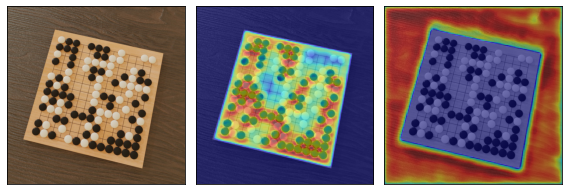

(<Figure size 576x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb32ccc0970>,
       dtype=object))

In [60]:
viz.visualize_image_attr_multiple(upsampled_gc_attr[0].cpu().permute(1,2,0).detach().numpy(),original_image=test,signs=["all", "positive", "negative"],methods=["original_image", "blended_heat_map","blended_heat_map"], cmap="jet")

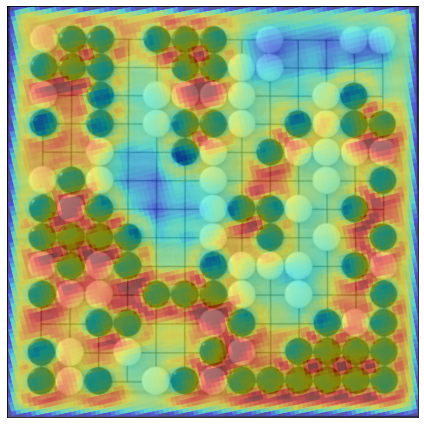

(<Figure size 576x432 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7fb32cb973a0>])

In [61]:
mt = MaskTransformer(model, 128)
pt = PerspectiveTransformer()

img, mask ,poly = mt.transform(test)
attr_warped = torch.tensor(pt.warp(upsampled_gc_attr[0].cpu().permute(1,2,0).detach().numpy(), poly.reshape(4,2)))
viz.visualize_image_attr_multiple(attr_warped.view(1,1,800,800)[0].cpu().permute(1,2,0).detach().numpy(), original_image=img, signs=["positive"], methods=["blended_heat_map"], cmap="jet")

# References

[1] **Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization**, *Ramprasaath R. Selvaraju, Michael Cogswell, et al.*